## Implement and test Naive Bayes classifier

In [1]:
import sys
sys.path.append("/Users/andyreagan/tools/python/labMTsimple/")
from labMTsimple.speedy import *
from labMTsimple.storyLab import *

import re
import codecs
from os import listdir,mkdir
from os.path import isfile,isdir
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc,rcParams
rc("xtick", labelsize=8)
rc("ytick", labelsize=8)
rc("font",**{"family":"serif","serif":["cmr10"]})
# rc("text", usetex=True)
figwidth_onecol = 8.5
figwidth_twocol = figwidth_onecol/2

import numpy as np
from json import loads
import csv
from datetime import datetime,timedelta
import pickle

error_logging = True
sys.path.append("/Users/andyreagan/tools/python/kitchentable")
from dogtoys import *

In [2]:
def loadMovieReviews():
    posfiles = ["../data/moviereviews/txt_sentoken/pos/"+x for x in listdir("../data/moviereviews/txt_sentoken/pos") if ".txt" in x]
    negfiles = ["../data/moviereviews/txt_sentoken/neg/"+x for x in listdir("../data/moviereviews/txt_sentoken/neg") if ".txt" in x]
    poswordcounts = dict()
    allwordcounts = dict()
    for file in posfiles:
        f = open(file,"r")
        postext = f.read() + " "
        f.close()
        dictify_general(postext,poswordcounts)
        dictify_general(postext,allwordcounts)
    negwordcounts = dict()
    for file in negfiles:
        f = open(file,"r")
        negtext = f.read() + " "
        f.close()
        dictify_general(negtext,negwordcounts)
        dictify_general(negtext,allwordcounts)

    print("there are {0} unique words in this corpus".format(len(allwordcounts)))

    # rip those dictionaries into lists for sorting
    allwordsList = [word for word in allwordcounts]
    allcountsList = [allwordcounts[allwordsList[i]] for i in range(len(allwordsList))]

    # sort them
    indexer = sorted(range(len(allcountsList)), key=lambda k: allcountsList[k], reverse=True)
    allcountsListSorted = np.array([float(allcountsList[i]) for i in indexer])
    allwordsListSorted = [allwordsList[i] for i in indexer]

    return allcountsListSorted,allwordsListSorted

In [3]:
def bayes_score(all_counts,pos_params,neg_params,my_counts):
    # uses all_counts_1k
    # uses pos_params
    # uses neg_params

    # compute conditional
    prob_pos = my_counts*pos_params/(all_counts/sum(all_counts))
    prob_neg = my_counts*neg_params/(all_counts/sum(all_counts))
    # add these things up carefulls
    log_prob_pos = 0.0
    for p in prob_pos:
        if p > 0:
            log_prob_pos += np.log(p)
    log_prob_neg = 0.0
    for p in prob_neg:
        if p > 0:
            log_prob_neg += np.log(p)

    # normalize post-hoc
    p_d = log_prob_pos+log_prob_neg

    # return the difference
    # if > 0, positive review
    return log_prob_pos/p_d - log_prob_neg/p_d

In [4]:
def train_bayes(all_words_1k,poswordcounts,negwordcounts):
    """Train bayes classifier using sorted word list, and dictionaries of counts from the two classes. Return the parameters"""
    pos_counts = np.array([float(poswordcounts[word]) if word in poswordcounts else 0.0 for word in all_words_1k])
    neg_counts = np.array([float(negwordcounts[word]) if word in negwordcounts else 0.0 for word in all_words_1k])
    # print(pos_counts[:10])

    # smoothing parameter
    alpha = 1.0
    pos_params = (pos_counts+alpha)/(np.sum(pos_counts)+alpha*len(pos_counts))
    # print(pos_params[:10])

    neg_params = (neg_counts+alpha)/(np.sum(neg_counts)+alpha*len(neg_counts))
    # print(neg_params[:10])

    return pos_params,neg_params

In [5]:
def naive_bayes():
    posfiles = ["../data/moviereviews/txt_sentoken/pos/"+x for x in listdir("../data/moviereviews/txt_sentoken/pos") if ".txt" in x]
    negfiles = ["../data/moviereviews/txt_sentoken/neg/"+x for x in listdir("../data/moviereviews/txt_sentoken/neg") if ".txt" in x]

    print(len(posfiles))
    print(len(negfiles))
    # randomly select N reviews for training
    training_size = 1400

    pos_files_training = np.random.choice(np.arange(len(posfiles)),size=training_size/2,replace=False)
    print(pos_files_training)
    # go add up all the words for training
    poswordcounts = dict()
    for file in [posfiles[i] for i in pos_files_training]:
        f = open(file,"r")
        postext = f.read()
        f.close()
        dictify_general(postext,poswordcounts)
    # select the negative reviews for training
    neg_files_training = np.random.choice(np.arange(len(negfiles)),size=training_size/2,replace=False)
    print(neg_files_training)
    # go add up the words
    negwordcounts = dict()
    for file in [negfiles[i] for i in neg_files_training]:
        f = open(file,"r")
        negtext = f.read()
        f.close()
        dictify_general(negtext,negwordcounts)

    all_counts,all_words = loadMovieReviews()
    # take the top 1000 words
    all_counts_1k = all_counts[30:5000]
    all_words_1k = all_words[30:5000]
    # build this for speed later
    all_words_1k_dict = dict()
    for i,word in enumerate(all_words_1k):
        all_words_1k_dict[word] = i

    pos_params,neg_params = train_bayes(all_words_1k,poswordcounts,negwordcounts)

    # classify all positive reviews
    print("positive reviews")
    correct_pos = np.zeros(len(posfiles)-training_size/2)
    for i,file in enumerate([posfiles[i] for i in range(len(posfiles)) if i not in pos_files_training]):
        f = open(file,"r")
        postext = f.read()
        f.close()
        my_poswordcounts = dict()
        dictify_general(postext,my_poswordcounts)
        my_pos_counts = np.array([float(my_poswordcounts[word]) if word in my_poswordcounts else 0.0 for word in all_words_1k])

        score = bayes_score(all_counts_1k,pos_params,neg_params,my_pos_counts)

        if score > 0:
            correct_pos[i] = 1

    pos_accuracy = sum(correct_pos)/len(correct_pos)
    print(sum(correct_pos)/len(correct_pos))

    # classify all negative reviews
    print("negative reviews")
    correct_neg = np.zeros(len(negfiles)-training_size/2)
    for i,file in enumerate([negfiles[i] for i in range(len(negfiles)) if i not in neg_files_training]):
        f = open(file,"r")
        negtext = f.read()
        f.close()
        my_wordcounts = dict()
        dictify_general(negtext,my_wordcounts)
        my_counts = np.array([float(my_wordcounts[word]) if word in my_wordcounts else 0.0 for word in all_words_1k])

        score = bayes_score(all_counts_1k,pos_params,neg_params,my_counts)

        if score < 0:
            # print("correct, score={0}".format(score))
            correct_neg[i] = 1

    neg_accuracy = sum(correct_neg)/len(correct_neg)
    print(sum(correct_neg)/len(correct_neg))

    print("overall accuracy: {0:.1f}".format((pos_accuracy+neg_accuracy)/2*100))
    

    allLengths = [                   1,   2,   3,   5,   7, 10, 15, 25, 40, 60, 80,100,150,250,400,600,900,]
    allSamples = [int(np.floor(1000-training_size/2)),2000,1500,1500,1000,900,750,600,500,250,100, 75, 75, 40, 25, 15,  1,]
    # allLengths = []

    files = [posfiles[i] for i in range(len(posfiles)) if i not in pos_files_training]

    # store all of the scores here
    pos_results_all = [[] for i in range(len(allLengths))]
    # store the mean of those here
    pos_means = [0.0 for i in range(len(allLengths))]
    # store the std of those here
    pos_std = [0.0 for i in range(len(allLengths))]

    for k,numReviews in enumerate(allLengths):
        numSamples = allSamples[k]
        print("pos: taking {0} samples of {1} reviews".format(numSamples,numReviews))

        if numReviews == 1:
            choose_randomly = False
        else:
            choose_randomly = True

        scores = [0.0 for i in range(numSamples)]
        for i in range(numSamples):
            # print("on sample {0}".format(i))

            if choose_randomly:
                if len(files) > numReviews:
                    print("WARN the number of files {} is greater than reviews {}".format(len(files),numReviews))
                my_files = np.random.choice(files,size=min([numReviews,len(files)]),replace=False)
            else:
                my_files = [files[i]]

            # forget the string expansion
            # let"s store them as a dict
            # allwordcounts = dict()
            # nah, let's store them as in the vector
            allwordcounts = np.zeros(len(all_counts_1k))
            for file in my_files:
                ########################################
                # this loads the files
                f = open(file,"r")
                rawtext = f.read()
                f.close()
                # add to the full dict
                # dictify_general(rawtext,allwordcounts)
                # add it to the vector
                my_list = listify(rawtext)
                for word in my_list:
                    if word in all_words_1k_dict:
                        allwordcounts[all_words_1k_dict[word]] += 1

            scores[i] = bayes_score(all_counts_1k,pos_params,neg_params,allwordcounts)

        # now save those scores
        pos_results_all[k] = scores
        pos_means[k] = np.mean(scores)
        print("mean score is {0}".format(pos_means[k]))
        pos_std[k] = np.std(scores)

    files = [negfiles[i] for i in range(len(negfiles)) if i not in neg_files_training]

    # store all of the scores here
    neg_results_all = [[] for i in range(len(allLengths))]
    # store the mean of those here
    neg_means = [0.0 for i in range(len(allLengths))]
    # store the std of those here
    neg_std = [0.0 for i in range(len(allLengths))]

    for k,numReviews in enumerate(allLengths):
        numSamples = allSamples[k]
        print("neg: taking {0} samples of {1} reviews".format(numSamples,numReviews))

        if numReviews == 1:
            choose_randomly = False
        else:
            choose_randomly = True

        scores = [0.0 for i in range(numSamples)]
        for i in range(numSamples):
            # print("on sample {0}".format(i))

            if choose_randomly:
                if len(files) > numReviews:
                    print("WARN the number of files {} is greater than reviews {}".format(len(files),numReviews))
                my_files = np.random.choice(files,size=min([numReviews,len(files)]),replace=False)
            else:
                my_files = [files[i]]


            # forget the string expansion
            # let"s store them as a dict
            # allwordcounts = dict()
            # nah, let's store them as in the vector
            allwordcounts = np.zeros(len(all_counts_1k))
            for file in my_files:
                ########################################
                # this loads the files
                f = open(file,"r")
                rawtext = f.read()
                f.close()
                # add to the full dict
                # dictify_general(rawtext,allwordcounts)
                # add it to the vector
                my_list = listify(rawtext)
                for word in my_list:
                    if word in all_words_1k_dict:
                        allwordcounts[all_words_1k_dict[word]] += 1

            scores[i] = bayes_score(all_counts_1k,pos_params,neg_params,allwordcounts)

        # now save those scores
        neg_results_all[k] = scores
        neg_means[k] = np.mean(scores)
        print("mean score is {0}".format(neg_means[k]))
        neg_std[k] = np.std(scores)

    # print(neg_results_all)
    # print(pos_results_all)
    print(neg_means)
    print(pos_means)
    print(neg_std)
    print(pos_std)

    overlapping = np.zeros(len(allLengths))
    for i in range(len(allLengths)):
        average_score = np.mean(neg_results_all[i]+pos_results_all[i])
        overlapping[i] = float(len(np.where(pos_results_all[i] < average_score)[0]) + len(np.where(neg_results_all[i] > average_score)[0])) / ( len( neg_results_all[i] ) + len( pos_results_all[i] ) )

    print(overlapping)

    fig = plt.figure()
    ax1 = fig.add_axes([0.15,0.2,0.7,0.7])
    ax1.plot(np.log10(allLengths),overlapping,linewidth=2,color="#ef8a62",)
    ax1.set_xlabel("log10(Number of Reviews)")
    ax1.set_ylabel("Fraction overlapping")
    # xlim with a little space
    ax1.set_xlim(np.log10([allLengths[0]-.1,allLengths[-1]+.1])) 
    ax1.set_title("Sentiment over many random samples for {0}".format("Naive Bayes"))
    # mysavefig("moviereviews-scores-{0}.png".format("naive-bayes"))
    mysavefig("moviereviews-scores-{0}.pdf".format("naive-bayes"),folder="../figures/NB")
    plt.close(fig)

    fig = plt.figure()
    ax1 = fig.add_axes([0.15,0.2,0.7,0.7])
    ax1.errorbar(np.log10(allLengths),pos_means,pos_std,linewidth=2,color="#ef8a62",)
    ax1.errorbar(np.log10(allLengths),neg_means,neg_std,linewidth=2,color="#2b8cbe",)
    ax1.legend(["Positive reviews","Negative reviews"],loc="best")
    ax1.set_xlabel("log10(Number of Reviews)")
    ax1.set_ylabel("Sentiment")
    # xlim with a little space
    ax1.set_xlim(np.log10([allLengths[0]-.1,allLengths[-1]+.1])) 
    # ax1.set_ylim([0,24])
    # plt.xticks([float(i)+0.5 for i in range(4)])
    # plt.yticks([float(i)+0.5 for i in range(3)])
    # ax1.set_xticklabels([1,5,25,50])
    # ax1.set_yticklabels([22,28,35])
    ax1.set_title("Sentiment over many random samples for {0}".format("Naive Bayes"))
    # mysavefig("moviereviews-{0}.png".format("naive-bayes"))
    mysavefig("moviereviews-{0}.pdf".format("naive-bayes"),folder="../figures/NB")
    plt.close(fig)

In [6]:
def NB_on_NYT():
    """Train NB on movie reviews, test it on NYT Society section."""

    print("training")
    posfiles = ["../data/moviereviews/txt_sentoken/pos/"+x for x in listdir("../data/moviereviews/txt_sentoken/pos") if ".txt" in x]
    negfiles = ["../data/moviereviews/txt_sentoken/neg/"+x for x in listdir("../data/moviereviews/txt_sentoken/neg") if ".txt" in x]

    # randomly select N reviews for training
    training_size = 1400

    pos_files_training = np.random.choice(np.arange(len(posfiles)),size=training_size/2,replace=False)
    # go add up all the words for training
    poswordcounts = dict()
    for file in [posfiles[i] for i in pos_files_training]:
        f = open(file,"r")
        postext = f.read()
        f.close()
        dictify_general(postext,poswordcounts)
    # select the negative reviews for training
    neg_files_training = np.random.choice(np.arange(len(negfiles)),size=training_size/2,replace=False)
    # go add up the words
    negwordcounts = dict()
    for file in [negfiles[i] for i in neg_files_training]:
        f = open(file,"r")
        negtext = f.read()
        f.close()
        dictify_general(negtext,negwordcounts)

    all_counts,all_words = loadMovieReviews()
    # take the top 1000 words
    all_counts_1k = all_counts[30:5000]
    all_words_1k = all_words[30:5000]
    # build this for speed later
    all_words_1k_dict = dict()
    for i,word in enumerate(all_words_1k):
        all_words_1k_dict[word] = i

    pos_params,neg_params = train_bayes(all_words_1k,poswordcounts,negwordcounts)

    # above from naive_bayes() function
    # now get the NYT section loaded
    print("loading NYT")
    sections = ["arts","books","classified","cultural","editorial","education","financial","foreign","home","leisure","living","magazine","metropolitan","movies","national","regional","science","society","sports","style","television","travel","week-in-review","weekend",]
    scores = np.zeros(len(sections))
    for i,section in enumerate(sections):
        a = pickle.load( open("../data/nyt/sections/NYT_{0}.dict".format(section), "rb") )

        allwordcounts = np.zeros(len(all_counts_1k))
        for word in a:
            if word in all_words_1k_dict:
                allwordcounts[all_words_1k_dict[word]] = a[word]

        print("scoring")
        score = bayes_score(all_counts_1k,pos_params,neg_params,allwordcounts)
        print("{0} score={1}".format(section,score))
        scores[i] = score
    indexer = sorted(range(len(scores)),key=lambda k: scores[k],reverse=True)
    sections_sorted = [sections[i] for i in indexer]
    my_happs_sorted = np.array([scores[i] for i in indexer])
    print(sections_sorted)

    avg_happs_unweighted = my_happs_sorted.mean()

    fig = plt.figure(figsize=(12,10))
    ax = fig.add_axes([.2,.2,.7,.7])
    # ax.bar(np.arange(len(sections)),np.array(my_happs_sorted),orientation="vertical")
    # ax.bar(0,.8,np.array(my_happs_sorted)-avg_happs,bottom=np.arange(len(sections)),orientation="horizontal")
    bar_height = 0.8
    happs_diff = np.array(my_happs_sorted)-avg_happs_unweighted
    rects1 = ax.bar(0,bar_height,happs_diff,bottom=np.arange(len(sections)),orientation="horizontal")
    ax.set_ylim([bar_height-1,len(sections)])
    ax.invert_yaxis()
    ax.set_yticklabels([])
    ax.set_xlabel("Happs diff from unweighted average")
    ax.set_title("Ranking of NYT Sections by {0}".format("NB"))

    def autolabel(rects):
        # attach some text labels
        for rect in rects:
            height = rect.get_height()
            width = rect.get_width()
            y = int(np.floor(rect.get_y()))

            x = rect.get_x()
            if happs_diff[y] > 0:
                ax.text(-0.0005, y+bar_height/2., "{0}. {1}".format(y+1,sections_sorted[y].capitalize()),
                        ha="right", va="center")
            else:
                ax.text(.0005, y+bar_height/2., "{0}. {1}".format(y+1,sections_sorted[y].capitalize()),
                        ha="left", va="center")

    autolabel(rects1)

    # mysavefig("NYT-sorted-{0}.png".format("NB"))
    mysavefig("NYT-sorted-{0}.pdf".format("NB"),folder="../figures/nyt")



In [7]:
def NB_wordshift(q=False):
    print("training")
    posfiles = ["../data/moviereviews/txt_sentoken/pos/"+x for x in listdir("../data/moviereviews/txt_sentoken/pos") if ".txt" in x]
    negfiles = ["../data/moviereviews/txt_sentoken/neg/"+x for x in listdir("../data/moviereviews/txt_sentoken/neg") if ".txt" in x]

    # randomly select N reviews for training
    training_size = 1400

    pos_files_training = np.random.choice(np.arange(len(posfiles)),size=training_size/2,replace=False)
    # go add up all the words for training
    poswordcounts = dict()
    for file in [posfiles[i] for i in pos_files_training]:
        f = open(file,"r")
        postext = f.read()
        f.close()
        dictify_general(postext,poswordcounts)
    # select the negative reviews for training
    neg_files_training = np.random.choice(np.arange(len(negfiles)),size=training_size/2,replace=False)
    # go add up the words
    negwordcounts = dict()
    for file in [negfiles[i] for i in neg_files_training]:
        f = open(file,"r")
        negtext = f.read()
        f.close()
        dictify_general(negtext,negwordcounts)

    all_counts,all_words = loadMovieReviews()
    # take the top 1000 words
    all_counts_1k = all_counts[30:5000]
    all_words_1k = all_words[30:5000]
    # build this for speed later
    all_words_1k_dict = dict()
    for i,word in enumerate(all_words_1k):
        all_words_1k_dict[word] = i

    pos_params,neg_params = train_bayes(all_words_1k,poswordcounts,negwordcounts)

    my_counts = np.ones(len(all_counts_1k))
    # given a text word vector my_counts, the unweighted probabilities are this
    prob_pos = my_counts*pos_params/(all_counts_1k/sum(all_counts_1k))
    prob_neg = my_counts*neg_params/(all_counts_1k/sum(all_counts_1k))
    # really just each vector multiplied together
    # but we take the log, and sum (for floating point-ness)
    
    # now let's normalize this, per peer request:
    prob_pos = prob_pos/prob_pos.sum()
    prob_neg = prob_neg/prob_neg.sum()

    # using 1's, and taking the max of the ratios will give the most informative
    ratio_pos = prob_pos/prob_neg
    ratio_neg = prob_neg/prob_pos

    indexer = sorted(range(len(ratio_pos)),key=lambda k: ratio_pos[k],reverse=True)
    ratio_pos_sorted = [ratio_pos[i] for i in indexer]
    words_pos_sorted = [all_words_1k[i] for i in indexer]
    indexer = sorted(range(len(ratio_pos)),key=lambda k: ratio_neg[k],reverse=True)
    ratio_neg_sorted = [ratio_neg[i] for i in indexer]
    words_neg_sorted = [all_words_1k[i] for i in indexer]
    
    movie_results = [[],[],[],[]]

    if not q:
        print("-"*80)
        print("-"*80)
        print("top positive words:")
    for i in range(10):
        movie_results[0].append([ratio_pos_sorted[i],words_pos_sorted[i]])
        if not q:
            print("{1}: {0}".format(ratio_pos_sorted[i],words_pos_sorted[i]))
    if not q:
        print("-"*80)
        print("top negative words:")
    for i in range(10):
        movie_results[1].append([ratio_neg_sorted[i],words_neg_sorted[i]])
        if not q:
            print("{1}: {0}".format(ratio_neg_sorted[i],words_neg_sorted[i]))
    if not q:
        print("-"*80)
        print("-"*80)

    # using 1's, and taking the max of the ratios will give the most informative
    diff_pos = prob_pos-prob_neg
    diff_neg = prob_neg-prob_pos

    indexer = sorted(range(len(diff_pos)),key=lambda k: diff_pos[k],reverse=True)
    diff_pos_sorted = [diff_pos[i] for i in indexer]
    words_pos_sorted = [all_words_1k[i] for i in indexer]
    indexer = sorted(range(len(diff_neg)),key=lambda k: diff_neg[k],reverse=True)
    diff_neg_sorted = [diff_neg[i] for i in indexer]
    words_neg_sorted = [all_words_1k[i] for i in indexer]

    if not q:
        print("top positive words:")
    for i in range(10):
        movie_results[2].append([diff_pos_sorted[i],words_pos_sorted[i]])
        if not q:
            print("{1}: {0}".format(diff_pos_sorted[i],words_pos_sorted[i]))
    if not q:
        print("-"*80)
        print("top negative words:")
    for i in range(10):
        movie_results[3].append([diff_neg_sorted[i],words_neg_sorted[i]])
        if not q:
            print("{1}: {0}".format(diff_neg_sorted[i],words_neg_sorted[i]))
    if not q:
        print("-"*80)
        print("-"*80)
    
    section="society"
    a = pickle.load( open("../data/nyt/sections/NYT_{0}.dict".format(section), "rb") )

    allwordcounts = np.zeros(len(all_counts_1k))
    for word in a:
        if word in all_words_1k_dict:
            allwordcounts[all_words_1k_dict[word]] = a[word]

    prob_pos = allwordcounts*pos_params/(all_counts_1k/sum(all_counts_1k))
    prob_neg = allwordcounts*neg_params/(all_counts_1k/sum(all_counts_1k))
    
    # now let's normalize this, per peer request:
    prob_pos = prob_pos/prob_pos.sum()
    prob_neg = prob_neg/prob_neg.sum()

    # using 1's, and taking the max of the ratios will give the most informative
    ratio_pos = prob_pos/prob_neg
    ratio_neg = prob_neg/prob_pos

    indexer = sorted(range(len(ratio_pos)),key=lambda k: ratio_pos[k],reverse=True)
    ratio_pos_sorted = [ratio_pos[i] for i in indexer]
    words_pos_sorted = [all_words_1k[i] for i in indexer]
    indexer = sorted(range(len(ratio_pos)),key=lambda k: ratio_neg[k],reverse=True)
    ratio_neg_sorted = [ratio_neg[i] for i in indexer]
    words_neg_sorted = [all_words_1k[i] for i in indexer]
    
    times_results = [[],[],[],[]]

    if not q:
        print("-"*80)
        print("-"*80)
        print("top positive words:")
    for i in range(10):
        times_results[0].append([ratio_pos_sorted[i],words_pos_sorted[i]])
        if not q:
            print("{1}: {0}".format(ratio_pos_sorted[i],words_pos_sorted[i]))
    if not q:
        print("-"*80)
        print("top negative words:")
    for i in range(10):
        times_results[1].append([ratio_neg_sorted[i],words_neg_sorted[i]])
        if not q:
            print("{1}: {0}".format(ratio_neg_sorted[i],words_neg_sorted[i]))
    if not q:
        print("-"*80)
        print("-"*80)

    # using 1's, and taking the max of the ratios will give the most informative
    diff_pos = prob_pos-prob_neg
    diff_neg = prob_neg-prob_pos

    indexer = sorted(range(len(diff_pos)),key=lambda k: diff_pos[k],reverse=True)
    diff_pos_sorted = [diff_pos[i] for i in indexer]
    words_pos_sorted = [all_words_1k[i] for i in indexer]
    indexer = sorted(range(len(diff_neg)),key=lambda k: diff_neg[k],reverse=True)
    diff_neg_sorted = [diff_neg[i] for i in indexer]
    words_neg_sorted = [all_words_1k[i] for i in indexer]

    if not q:
        print("top positive words:")
    for i in range(10):
        times_results[2].append([diff_pos_sorted[i],words_pos_sorted[i]])
        if not q:
            print("{1}: {0}".format(diff_pos_sorted[i],words_pos_sorted[i]))
    if not q:
        print("-"*80)
        print("top negative words:")
    for i in range(10):
        times_results[3].append([diff_neg_sorted[i],words_neg_sorted[i]])
        if not q:
            print("{1}: {0}".format(diff_neg_sorted[i],words_neg_sorted[i]))
    if not q:
        print("-"*80)
        print("-"*80)

    score = bayes_score(all_counts_1k,pos_params,neg_params,allwordcounts)

    if not q:
        print("{0} score={1}".format(section,score))
    
    return movie_results,times_results

In [8]:
def bayes_many_samples(n_trials):
    posfiles = ["../data/moviereviews/txt_sentoken/pos/"+x for x in listdir("../data/moviereviews/txt_sentoken/pos") if ".txt" in x]
    negfiles = ["../data/moviereviews/txt_sentoken/neg/"+x for x in listdir("../data/moviereviews/txt_sentoken/neg") if ".txt" in x]

    results = [0.0 for i in range(n_trials)]
    n_stopwords = 0

    for trial_i in range(n_trials):

        print(len(posfiles))
        print(len(negfiles))
        # randomly select N reviews for training
        training_size = 200
    
        pos_files_training = np.random.choice(np.arange(len(posfiles)),size=training_size/2,replace=False)
        print(pos_files_training)
        # go add up all the words for training
        poswordcounts = dict()
        for file in [posfiles[i] for i in pos_files_training]:
            f = open(file,"r")
            postext = f.read()
            f.close()
            dictify_general(postext,poswordcounts)
        # select the negative reviews for training
        neg_files_training = np.random.choice(np.arange(len(negfiles)),size=training_size/2,replace=False)
        print(neg_files_training)
        # go add up the words
        negwordcounts = dict()
        for file in [negfiles[i] for i in neg_files_training]:
            f = open(file,"r")
            negtext = f.read()
            f.close()
            dictify_general(negtext,negwordcounts)
    
        all_counts,all_words = loadMovieReviews()
        # take the top 1000 words
        all_counts_1k = all_counts[n_stopwords:5000]
        all_words_1k = all_words[n_stopwords:5000]
        # build this for speed later
        all_words_1k_dict = dict()
        for i,word in enumerate(all_words_1k):
            all_words_1k_dict[word] = i
    
        pos_params,neg_params = train_bayes(all_words_1k,poswordcounts,negwordcounts)
    
        # classify all positive reviews
        print("positive reviews")
        correct_pos = np.zeros(len(posfiles)-training_size/2)
        for i,file in enumerate([posfiles[i] for i in range(len(posfiles)) if i not in pos_files_training]):
            f = open(file,"r")
            postext = f.read()
            f.close()
            my_poswordcounts = dict()
            dictify_general(postext,my_poswordcounts)
            my_pos_counts = np.array([float(my_poswordcounts[word]) if word in my_poswordcounts else 0.0 for word in all_words_1k])
    
            score = bayes_score(all_counts_1k,pos_params,neg_params,my_pos_counts)
    
            if score > 0:
                correct_pos[i] = 1
    
        pos_accuracy = sum(correct_pos)/len(correct_pos)
        print(sum(correct_pos)/len(correct_pos))
    
        # classify all negative reviews
        print("negative reviews")
        correct_neg = np.zeros(len(negfiles)-training_size/2)
        for i,file in enumerate([negfiles[i] for i in range(len(negfiles)) if i not in neg_files_training]):
            f = open(file,"r")
            negtext = f.read()
            f.close()
            my_wordcounts = dict()
            dictify_general(negtext,my_wordcounts)
            my_counts = np.array([float(my_wordcounts[word]) if word in my_wordcounts else 0.0 for word in all_words_1k])
    
            score = bayes_score(all_counts_1k,pos_params,neg_params,my_counts)
    
            if score < 0:
                # print("correct, score={0}".format(score))
                correct_neg[i] = 1
    
        neg_accuracy = sum(correct_neg)/len(correct_neg)
        print(sum(correct_neg)/len(correct_neg))
    
        print("overall accuracy: {0:.1f}".format((pos_accuracy+neg_accuracy)/2*100))
        results[trial_i] = (pos_accuracy+neg_accuracy)/2*100
        
    print(np.mean(results))

In [9]:
naive_bayes()

1000
1000
[518 199 445 981 683 773  15 982 366 384 901 412 196 332 555 212 587 794
 903  89 711 606 292 567 121 804 187 543 623 893 499 658 428 771  27 524
 740  39 390  17 509 426 627 933 629 549 243 851 381 318 958 897 316 979
 254 409 961 193 777 158 150 922 641 534  26  36  47 547 972 388  21  88
 919 618 833 299 456 672 468 211 622 610 991  99 252 686 286 106 134 298
 573 152 948 178 728 484 655 776 348 956 508 700 945  44 621 471 506 268
 383 910  63 323 164 647 898 676 712 186 255 371 429 883 156  52 386 574
 148 520 786 663 111 867 822 439 302 895   6 783 100 345 251 966 887 112
 957 249 619 666 782 685 544 704 259   8 125 474 469 579 450 492 949 233
 950 998  64 876 984  85 774 669 423  92  68 875 161 213 194 586 904 640
 322 119 432 300 458  61 767 908 924   1 720 801 217 612 372  46 857 188
 352 277 170 889  13 355 442 470 785 248 168 863 856 937 143  77  62 403
 265 697 441  51 943 303  42 175 724 467 264 553 477 821 986 690 878 123
 860 882 759 367 334 695 127 266  79 307 

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[530  72  15 965 373 400 652 856 719 299 339 684 800 460 488 379 509 225
 194  93 829 374 560 819 676 681 304 263 730 116 598 885 466   9 390  69
 704 165  19 894 751 888 690 776 665 329 244 266   3  20 318 967  84 251
 271 892  51 310 470 219 377 478 864 919 118 754  82 554 574 180 288 495
 491 227 202 103 586 455 296  63 644 402 559 834 192 141 511 765 981 311
 569  37 389 550 295 670 866  59 602 436 740 417 161 500 870 113 832 501
 741 380 859 958 599  67 298 932 101 186 172 336 948 841 208 978 210 306
 170 688  50 246 448 502 927 955  87 100 771  60 934 605 683 342 249  40
  65 880  91 553 486 990  29 813 215 907 975 591 694 985 844 415 245 675
 322 153 398 229 427 257 737 953 234 519 521 572 787 903 724 102 497 611
 481 809 902 230 273 410 615 637  74 513 886 806 651 324 458 195 255 444
 968 232 943 119 177 548 960 419 523 905 685 278 205 254 897 552 301  76
 220 933 924 381 680 716  81 700 445 520 626 541 646 671 213 744 160 442
 360 516 992 432 348 910 105 156 699 607 723 265 46

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:43: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0.816666666667
negative reviews


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:62: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0.82
overall accuracy: 81.8
pos: taking 300 samples of 1 reviews
mean score is 0.16209786041804677
pos: taking 2000 samples of 2 reviews
WARN the number of files 300 is greater than reviews 2
WARN the number of files 300 is greater than reviews 2
WARN the number of files 300 is greater than reviews 2
WARN the number of files 300 is greater than reviews 2
WARN the number of files 300 is greater than reviews 2
WARN the number of files 300 is greater than reviews 2
WARN the number of files 300 is greater than reviews 2
WARN the number of files 300 is greater than reviews 2
WARN the number of files 300 is greater than reviews 2
WARN the number of files 300 is greater than reviews 2
WARN the number of files 300 is greater than reviews 2
WARN the number of files 300 is greater than reviews 2
WARN the number of files 300 is greater than reviews 2
WARN the number of files 300 is greater than reviews 2
WARN the number of files 300 is greater than reviews 2
WARN the number of files 300 is greate

In [10]:
bayes_many_samples(10)

1000
1000
[682 141 681  28 322 497 562  78 525 590 341 323 131 867 412 966  26 936
 311 458 284 771 300 363  25 235 259 159 529 302 124  73  66 836 723 751
 585 148 714 195 890 957 376 108 848 929 296 319 449 394 383  17 865 385
 967 134 945 752 572 107 759 870 176 234 627 979 839 964 492 658 530 593
 370 395  38  39 659  65 484 960 196 657 828 502  71 405 168 560  75 450
 559 163 784 842 513 639 334 537 753 673]
[523 487 535 989 558 900 460 129 941 952 697 932  58 746 384 545 983 598
 675 346  80 103 203 403 964 533 538 873 231 833  18 175 335 851 606 778
 380 322 481 389 711 224 679 902 499 708 470 742  92 943 626 797 166 438
 503 841 521 978   1 524  68 770 857 148 394 211 422 622 332 257 908 296
 685 990 730 819 588 474  61 100 194 326 111 425 604  97 587  69 689 811
 642 832 382 876 504 486  23 189 721 519]


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


there are 43903 unique words in this corpus
positive reviews


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0.596666666667
negative reviews


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:67: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0.881111111111
overall accuracy: 73.9
1000
1000
[294 198 168 988  71 842 331 869 134 246 950 805 202  42 756 507 669  39
 452  57 258 358 217 197 509 203 911 346 129 630 253 694 523  34 123  22
 951 275 220 722 425 146 942 912 413 283 480 120 967 835 871 224  24 642
 955 671 584 687 381 707 351 259 780 892 231 375 393 740 781 501 228 612
 807 773 366 502 999 432 675 596 206 493 321 982 162 534 533 904 776 506
 810 935 180 628  59 816 739 293 938 406]
[373 451 441 399 111 206  40 724 810 119  41 345 140 125 610  91 303 259
 569 993  20 496 479 427 538 589 445 356 798 446 242 153  50 867 915  34
 262 606 747  48   9 508 310  44 674 945 308 251 959  72 444 614 555 365
 480 272 830 404 656 633 287 926 122 285 708 406 384 968 174 953 166 301
 788 840 133 690 691 339 975  97 123 642 678 192 716 393 782 793 988 759
 631 946 430 475 440 629 191 592 787 377]
there are 43903 unique words in this corpus
positive reviews
0.656666666667
negative reviews
0.865555555556
overall accuracy: 76.1
1000
10

training


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


there are 43903 unique words in this corpus
loading NYT
scoring
arts score=0.0033158335091799107
scoring
books score=0.003624907404319311
scoring
classified score=0.0044738862219352304
scoring
cultural score=0.003562188181493564
scoring
editorial score=0.0033862269066537443
scoring
education score=0.016501169147533412
scoring
financial score=0.003231139994461507
scoring
foreign score=0.0034136346496850822
scoring
home score=0.004713973950659978
scoring
leisure score=0.00433865773634573
scoring
living score=0.004959415398887279
scoring
magazine score=0.003679127991519038
scoring
metropolitan score=0.003145808579018361
scoring
movies score=0.00404955921057315
scoring
national score=0.00318577113839813
scoring
regional score=0.003332836285585783
scoring
science score=0.004269648815621752
scoring
society score=0.004992265847704791
scoring
sports score=0.0031181414564518395
scoring
style score=0.004406697496241063
scoring
television score=0.06127256269112652
scoring
travel score=0.114405946

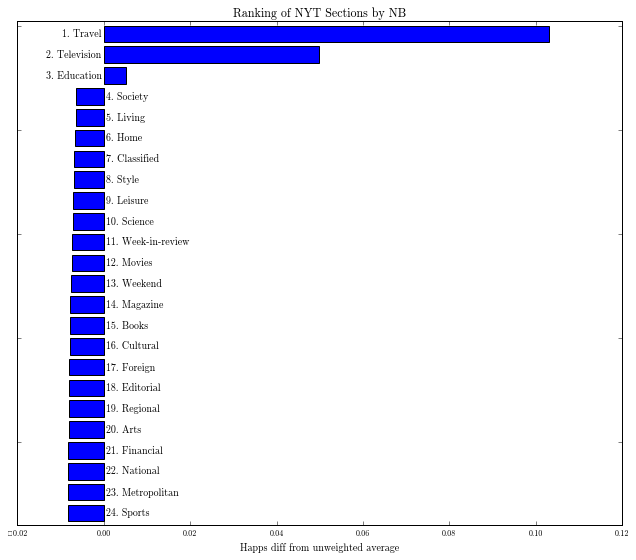

In [11]:
NB_on_NYT()

In [12]:
mr,tr = NB_wordshift()

training


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


there are 43903 unique words in this corpus
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
top positive words:
shrek: 36.63003144422874
ordell: 32.269313415153896
mulan: 27.036451780264077
leila: 26.16430817444911
sweetback: 24.420020962819162
flynt: 21.367518342466767
lambeau: 20.931446539559285
truman's: 20.059302933744313
mallory: 19.187159327929344
scorsese: 18.315015722114374
--------------------------------------------------------------------------------
top negative words:
&nbsp: 67.64940957729976
insulting: 32.10480454515921
jakob: 29.81160422050498
schumacher: 27.518403895850753
seagal: 26.945103814687197
brenner: 25.22520357119652
burn: 25.22520357119652
stupidity: 22.932003246542298
sphere: 18.34560259723384
judith: 18.345602597233835
--------------------------------------------------------------------------------
------------------------------------------------

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:125: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:126: RuntimeWarning: invalid value encountered in true_divide


In [13]:
mr

[[[36.630031444228742, 'shrek'],
  [32.269313415153896, 'ordell'],
  [27.036451780264077, 'mulan'],
  [26.164308174449111, 'leila'],
  [24.420020962819162, 'sweetback'],
  [21.367518342466767, 'flynt'],
  [20.931446539559285, 'lambeau'],
  [20.059302933744313, "truman's"],
  [19.187159327929344, 'mallory'],
  [18.315015722114374, 'scorsese']],
 [[67.649409577299764, '&nbsp'],
  [32.104804545159212, 'insulting'],
  [29.811604220504979, 'jakob'],
  [27.518403895850753, 'schumacher'],
  [26.945103814687197, 'seagal'],
  [25.22520357119652, 'brenner'],
  [25.22520357119652, 'burn'],
  [22.932003246542298, 'stupidity'],
  [18.345602597233839, 'sphere'],
  [18.345602597233835, 'judith']],
 [[0.00050984543362558204, 'ordell'],
  [0.00050934223124984683, 'leila'],
  [0.00050915053510670937, 'sweetback'],
  [0.00048747266379801479, 'lambeau'],
  [0.00044481181969949809, 'mallory'],
  [0.00044324829803203458, 'amistad'],
  [0.0004324916401534363, 'lebowski'],
  [0.0004220979431813694, 'whale'],


In [14]:
def to_table(my_list,my_fname):
    f = open(my_fname,"w")
    for j in range(10):
        table_strings = [my_list[i][j] for i in range(4)]
        table_strings = ["{0:.2f} & {1}".format(my_list[i][j][0],my_list[i][j][1]) for i in range(2)]+["{0:.4f} & {1}".format(my_list[i][j][0],my_list[i][j][1]) for i in range(2,4)]
        full_string = " & ".join(table_strings)
        f.write(full_string)
        f.write(r" \\")
        f.write("\n")
    f.close()
        

In [15]:
to_table(mr,"../figures/NB/output-003-table-MR.tex")

In [16]:
to_table(tr,"../figures/NB/output-003-table-TR.tex")

In [17]:
mr,tr = NB_wordshift(q=True)
to_table(mr,"../figures/NB/output-004-table-MR.tex")
to_table(tr,"../figures/NB/output-004-table-TR.tex")

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


training


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


there are 43903 unique words in this corpus


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:125: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:126: RuntimeWarning: invalid value encountered in true_divide


In [18]:
mr,tr = NB_wordshift(q=True)
to_table(mr,"../figures/NB/output-005-table-MR.tex")
to_table(tr,"../figures/NB/output-005-table-TR.tex")

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


training


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


there are 43903 unique words in this corpus


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:125: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:126: RuntimeWarning: invalid value encountered in true_divide


In [19]:
mr,tr = NB_wordshift(q=True)
to_table(mr,"../figures/NB/output-006-table-MR.tex")
to_table(tr,"../figures/NB/output-006-table-TR.tex")

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


training


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


there are 43903 unique words in this corpus


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:125: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:126: RuntimeWarning: invalid value encountered in true_divide
